# C-VAE for MNIST

For further information read the [Conditional Variational Autoencoder tutorial](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/).

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set Hyper-parameters (change None)
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
N_EPOCH = 100


In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=original_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=original_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


0it [00:00, ?it/s]

9920512it [00:01, 8749824.82it/s]                            


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 109125.56it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


1654784it [00:00, 2258062.33it/s]                            
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


8192it [00:00, 53510.09it/s]            


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


In [0]:
class CVAE(nn.Module):
    def __init__(self, x_dim, z_dim, c_dim):
        super(CVAE, self).__init__()
        
        #######################################
        ##       Define Encoder layers       ##
        ## use linear or convolutional layer ##
        #######################################
        self.linear = nn.Linear(x_dim+c_dim , 256)
        self.mu = nn.Linear(256, z_dim)
        self.var = nn.Linear(256, z_dim)
        #######################################
        ##       Define Decoder layers       ##
        ## use linear or convolutional layer ##
        #######################################
        self.latent_to_hidden = nn.Linear(z_dim+c_dim, 256)
        self.hidden_to_out = nn.Linear(256, x_dim)
    def encoder(self, x, c):
        x = torch.cat((x, c), dim=1)
        hidden = F.relu(self.linear(x))
        mean = self.mu(hidden)
        log_var = self.var(hidden)
        return  mean, log_var
    
    def decoder(self, z, c):
        x = torch.cat((z, c), dim=1)
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = F.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]
        return  generated_x
    
    def sampling(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)
    
    
    def forward(self, x, c):
        z_mu, z_var = self.encoder(x,c)
        x_sample=self.sampling(z_mu,z_var)
        gene_x = self.decoder(x_sample,c)
        return gene_x,z_mu,z_var

In [0]:
# Create Model (change None)
cond_dim = 10
latent_dim = 75
cvae = CVAE(x_dim=28*28, z_dim=latent_dim, c_dim=cond_dim)

# Device setting
cvae = cvae.to(device)

In [80]:
# Your Model
cvae

CVAE(
  (linear): Linear(in_features=794, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=75, bias=True)
  (var): Linear(in_features=256, out_features=75, bias=True)
  (latent_to_hidden): Linear(in_features=85, out_features=256, bias=True)
  (hidden_to_out): Linear(in_features=256, out_features=784, bias=True)
)

In [0]:
######coefficient for both is one leads better reconstructed image
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    recon_loss = F.binary_cross_entropy(recon_x, x, size_average=False)
    return  0.001* kl_loss + 1.0* recon_loss #You can change constants

In [82]:
def idx2onehot(idx, n=10):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

# Train
for epoch in range(1, N_EPOCH + 1):
    cvae.train()
    train_loss = 0
    for (data, cond) in train_loader:
        data = data.view(-1, 28 * 28)
        data = data.to(device)

        # convert y into one-hot encoding
        cond= idx2onehot(cond.view(-1, 1))
        cond = cond.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {}/{}\t Average loss: {:.4f}'.format(epoch, N_EPOCH, train_loss / len(train_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 1/100	 Average loss: 114.4183
Epoch: 2/100	 Average loss: 71.9784
Epoch: 3/100	 Average loss: 65.4404
Epoch: 4/100	 Average loss: 62.1572
Epoch: 5/100	 Average loss: 60.1138
Epoch: 6/100	 Average loss: 58.6686
Epoch: 7/100	 Average loss: 57.6379
Epoch: 8/100	 Average loss: 56.8195
Epoch: 9/100	 Average loss: 56.2058
Epoch: 10/100	 Average loss: 55.7273
Epoch: 11/100	 Average loss: 55.3174
Epoch: 12/100	 Average loss: 54.9946
Epoch: 13/100	 Average loss: 54.7179
Epoch: 14/100	 Average loss: 54.4690
Epoch: 15/100	 Average loss: 54.2596
Epoch: 16/100	 Average loss: 54.0764
Epoch: 17/100	 Average loss: 53.8992
Epoch: 18/100	 Average loss: 53.7711
Epoch: 19/100	 Average loss: 53.6328
Epoch: 20/100	 Average loss: 53.5211
Epoch: 21/100	 Average loss: 53.4258
Epoch: 22/100	 Average loss: 53.3380
Epoch: 23/100	 Average loss: 53.2557
Epoch: 24/100	 Average loss: 53.1776
Epoch: 25/100	 Average loss: 53.1327
Epoch: 26/100	 Average loss: 53.0620
Epoch: 27/100	 Average loss: 53.0186
Epoch: 28

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 72x1440 with 0 Axes>

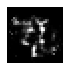

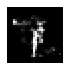

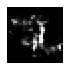

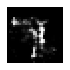

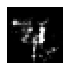

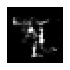

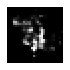

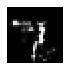

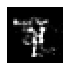

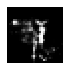

In [83]:
# Visualization
import numpy as np

import matplotlib.pyplot as plt

digit_size = 28
z_sample = np.random.rand(1, latent_dim) # random 
z_sample=torch.tensor(z_sample,device=device).float()
# z_sample=torch.randn(1, latent_dim).to(device)
plt.figure(figsize=(1, 20))

for i in range(10):
    c = np.zeros((1, cond_dim))
    c[0][i] = 1
    cvae.eval()
    with torch.no_grad():
        reconstructed_img = cvae.decoder(z_sample, torch.tensor(c, device=device).float())
        img = reconstructed_img.view(28, 28).data
        # reshape (if needed)
    plt.figure(figsize=(1, 20))
    plt.axis('off')
    plt.imshow(img.cpu(), cmap='Greys_r')
    plt.show()



# UMAP
These links help you to understand how UMAP works.

[Scanpy anndata](https://anndata.readthedocs.io/en/stable/)

[Scanpy umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html)

[Example](https://icb-scanpy-tutorials.readthedocs-hosted.com/en/latest/visualizing-marker-genes.html)

In [0]:
# Create latent space and labels for UMAP
cvae.eval()

latent = None
labels = None
with torch.no_grad():
    for data, cond in test_loader:
        data = data.view(-1, 28 * 28)
        data = data.to(device)
        
        if labels is None:
            labels = cond
        else:
            # concatenate labels and cond
            labels=torch.cat((labels,cond),dim=0)
            
        cond_o = idx2onehot(cond.view(-1, 1)) # create one-hot condition
        cond_o = cond_o.to(device)
        mu, log_var = cvae.encoder(data, cond_o)
        batch_latent = cvae.sampling(mu, log_var)
        if latent is None:
            latent = batch_latent
        else:
            # concatenate latent and batch_latent
            latent=torch.cat((latent,batch_latent),dim=0)



         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Numbers' as categorical


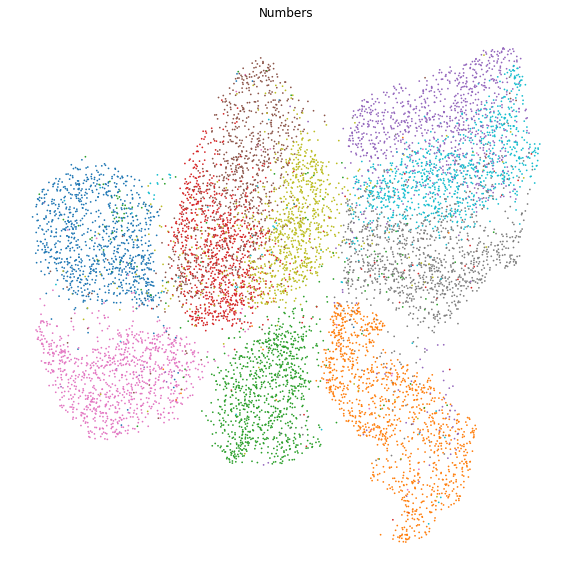

In [86]:
# UMAP
import scanpy as sc
from matplotlib import rcParams
labels_str = np.array(labels).astype(str)
# labels_str=torch.tensor(labels_str,device=device,dtype=torch.float32).float()
latent_anndata = sc.AnnData(X=latent.cpu().numpy()
,
                        obs={"Numbers": labels_str})
rcParams['figure.figsize'] = 10,10
sc.pp.neighbors(latent_anndata)
sc.tl.umap(latent_anndata)
# Visualization
sc.pl.umap(latent_anndata, color=["Numbers"],
           frameon=False,
           legend_loc=False,
           show=True)

In [0]:
_stest_loader=iter(test_loader)
data, target = next(test_loader)

In [0]:
!pip install scanpy